In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from scripts.parse_tests import parse_df

In [3]:
%matplotlib inline

plt.rcParams['font.family'] = 'PT Sans'

## Підготовка даних

Читаємо питання обидвох тестів

In [4]:
krok_df = parse_df('data/krok.txt')

In [5]:
usmle_df = parse_df('data/usmle.txt')

Читаємо питання USMLE, перекладені українською, щоб порівняти довжину

In [6]:
translations_df = pd.read_csv('data/translations.txt', header=0)

In [7]:
translations_df

,en_question_num,text
0,13,"4-річний хлопчик, який хворіє на муковісцидоз,..."
1,19,"34-річна жінка, біла, надійшла до відділення н..."
2,24,26-річна жінка прийшла на прийом до лікаря зі ...
3,37,"Жінка 63-х років, афроамериканка, перебуває у ..."
4,51,"68-річного чоловіка було госпіталізовано, оскі..."


Знаходимо англійські відповідники перекладеним українською питанням

In [8]:
usmle_df['N'] = usmle_df.N.astype(int)

In [9]:
translated_questions = pd.merge(
    usmle_df[['N', 'question_text']], translations_df, 
    right_on='en_question_num', left_on="N", how='inner'
)[['question_text', 'text']]
translated_questions.columns = ['en', 'uk']

In [10]:
def str_len(str_series):
    return str_series.str.replace(r'\s+', ' ').str.len()

Рахуємо у скільки разів в середньому український текст довший, ніж відподвіний англійський

In [11]:
translation_quot = str_len(translated_questions.uk) / str_len(translated_questions.en)

In [12]:
translation_quot.mean()

1.0749105401233714

In [13]:
translation_quot.std()

0.065086408330517029

In [14]:
krok_len = str_len(krok_df.question_text)
usmle_len = str_len(usmle_df.question_text)

## Порівняння питань за довжиною

Бачимо, що в середньому англійські питання більше ніж вдічі довші, ніж українські

In [15]:
usmle_len.mean() / krok_len.mean()

2.2454539842095089

In [16]:
(usmle_len * translation_quot.mean()).mean() / krok_len.mean()

2.4136621549888191

Половина англійських питань довші, за найдовше українське питання, a якщо зробити поправку на переклад, то ще більше.

In [17]:
(usmle_len > krok_len.max()).sum() / len(usmle_len)

0.5

In [18]:
(usmle_len * translation_quot.mean() > krok_len.max()).sum() / len(usmle_len)

0.54838709677419351

## Графіки

Переводимо дані у «довгу» форму, щоб намалювати графік

In [19]:
def convert_to_frame(series, test_name):
    df = series.to_frame('val')
    df['test'] = test_name
    return df

In [20]:
pivoted = pd.concat([
    convert_to_frame(krok_len, 'Крок'), 
    convert_to_frame(usmle_len, 'USMLE'),
    convert_to_frame(usmle_len * translation_quot.mean(), 'USMLE, скоригований'),
])

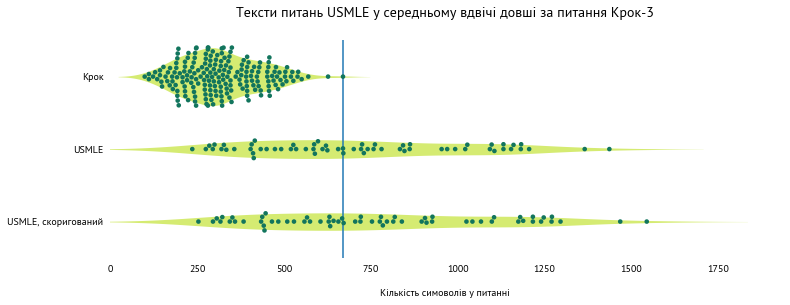

In [21]:
f, ax = plt.subplots(figsize=(12, 4))
# sns.boxplot(data=pivoted, y='test', x='val', color='white', width=.5, linewidth=1)
sns.violinplot(data=pivoted, y='test', x='val', inner=None, linewidth=0, color='#e2ff5e', ax=ax)
sns.swarmplot(data=pivoted, y='test', x='val', color='#12755d', size=4.6, ax=ax)
plt.axvline(krok_len.max())

ax.set_xlabel('Кількість симоволів у питанні', labelpad=15)
ax.set_title('Тексти питань USMLE у середньому вдвічі довші за питання Крок-3', fontdict={
    'y': 1.08, 'size': 14, 
})

ax.set_xlim(0)
ax.set_ylabel('')

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')

plt.savefig('./imgs/krok_vs_usmle_lenght_2.svg')

In [22]:
krok_len.max()

670

## Статистичний тест

Просто, тому що це щось, що я можу зробити, проведемо t-тест, щоб пересвідчитися, що довжини питань справді-справді відрізняються.

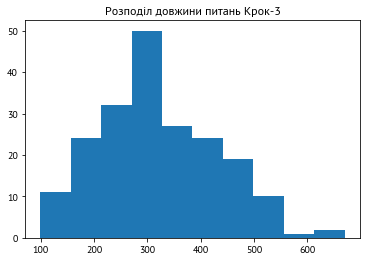

In [23]:
plt.hist(pivoted[pivoted['test'] == 'Крок']['val'])
plt.title('Розподіл довжини питань Крок-3')

Довжини англійських питань розподілені не зовсім нормально, крім того, хибно було би припускати, що питання одного тесту є випадковою вибіркою із загальної популяції питань, але ми все одно використаємо t-тест, бо це просто для себе.

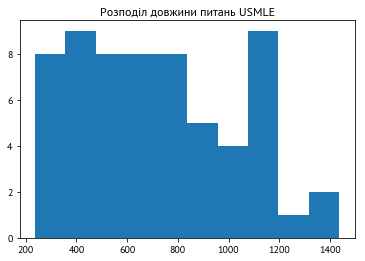

In [24]:
plt.hist(pivoted[pivoted['test'] == 'USMLE']['val'])
plt.title('Розподіл довжини питань USMLE')

In [25]:
stats.ttest_ind(usmle_len, krok_len)

Ttest_indResult(statistic=15.363787780894432, pvalue=2.4108800716508772e-38)

Отже, як і очікувалося, тут можна побачити статистично значущу різницю в довжині питань.